In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 

In [2]:
df1 = pd.read_csv('Delhi_v2.csv')
df1.head()

,Unnamed: 0,price,Address,area,latitude,longitude,Bedrooms,Bathrooms,Balcony,Status,neworold,parking,Furnished_status,Lift,Landmarks,type_of_building,desc,Price_sqft
0,0,5600000.0,"Noida Extension, Noida, Delhi NCR",1350.0,28.608850,77.460560,3.0,3.0,NaN,Under Construction,New Property,NaN,NaN,2.0,NaN,Flat,\n\n\n Welcome ...,4148.148148
1,1,8800000.0,"Sector 79, Gurgaon, Delhi NCR",1490.0,28.374236,76.952416,3.0,3.0,NaN,Ready to Move,New Property,NaN,Semi-Furnished,2.0,NaN,Flat,\n\n\n Mapsko M...,5906.040268
2,2,16500000.0,"Vaishali, Ghaziabad, Delhi NCR",2385.0,28.645769,77.385110,4.0,5.0,NaN,Ready to Move,New Property,1.0,Unfurnished,NaN,NaN,Flat,\n\n\n This pro...,6918.238994
3,3,3810000.0,"Link Road, F Block, Sector 50, Noida, Uttar Pr...",1050.0,28.566914,77.436434,2.0,2.0,3.0,NaN,New Property,1.0,Unfurnished,2.0,near Gaur Mulberry Mansion,Flat,\n\n\n AIG Roya...,3628.571429
4,4,6200000.0,"Jaypee Pavilion Court Sector 128, Noida, Secto...",1350.0,28.520732,77.356491,2.0,2.0,3.0,Ready to Move,Resale,1.0,NaN,3.0,NaN,Flat,\n\n\n The prop...,4592.592593


In [3]:
df1.shape

(7738, 18)

from the table above, there are several column that seems not related which are lattitude, longitude, balcony, status , landmarks, and desc. Those column will be eliminated in next process

# Data Cleaning

In [4]:
relatedcolumn = ['Address', 'area', 'Bedrooms', 'Bathrooms', 'neworold', 'type_of_building','parking','Furnished_status','Price_sqft','price']
df2 = df1[relatedcolumn]
df2.head()

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,parking,Furnished_status,Price_sqft,price
0,"Noida Extension, Noida, Delhi NCR",1350.0,3.0,3.0,New Property,Flat,NaN,NaN,4148.148148,5600000.0
1,"Sector 79, Gurgaon, Delhi NCR",1490.0,3.0,3.0,New Property,Flat,NaN,Semi-Furnished,5906.040268,8800000.0
2,"Vaishali, Ghaziabad, Delhi NCR",2385.0,4.0,5.0,New Property,Flat,1.0,Unfurnished,6918.238994,16500000.0
3,"Link Road, F Block, Sector 50, Noida, Uttar Pr...",1050.0,2.0,2.0,New Property,Flat,1.0,Unfurnished,3628.571429,3810000.0
4,"Jaypee Pavilion Court Sector 128, Noida, Secto...",1350.0,2.0,2.0,Resale,Flat,1.0,NaN,4592.592593,6200000.0


In [5]:
df2.shape

(7738, 10)

In [6]:
df2.isnull().sum()

Address                0
area                   0
Bedrooms               0
Bathrooms              0
neworold               0
type_of_building       0
parking             5126
Furnished_status    3614
Price_sqft             0
price                  0
dtype: int64

In [7]:
df3 = df2.drop(['parking','Furnished_status'], axis='columns')
df3.head()

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price
0,"Noida Extension, Noida, Delhi NCR",1350.0,3.0,3.0,New Property,Flat,4148.148148,5600000.0
1,"Sector 79, Gurgaon, Delhi NCR",1490.0,3.0,3.0,New Property,Flat,5906.040268,8800000.0
2,"Vaishali, Ghaziabad, Delhi NCR",2385.0,4.0,5.0,New Property,Flat,6918.238994,16500000.0
3,"Link Road, F Block, Sector 50, Noida, Uttar Pr...",1050.0,2.0,2.0,New Property,Flat,3628.571429,3810000.0
4,"Jaypee Pavilion Court Sector 128, Noida, Secto...",1350.0,2.0,2.0,Resale,Flat,4592.592593,6200000.0


### Checking data types

In [8]:
df3.dtypes

Address              object
area                float64
Bedrooms            float64
Bathrooms           float64
neworold             object
type_of_building     object
Price_sqft          float64
price               float64
dtype: object

### Check value of every column to see whether the value is make sense or not

In [9]:
df3['Bedrooms'].unique()

array([ 3.,  4.,  2.,  5.,  6., 10.,  7.,  8.,  9.])

In [10]:
df3['Bathrooms'].unique()

array([ 3.,  5.,  2.,  4.,  6., 10.,  7.,  8.,  9.])

In [11]:
df3['area'].unique()

array([1350., 1490., 2385., ..., 2374., 1692., 1898.])

In [12]:
df3['neworold'].unique()

array(['New Property', 'Resale'], dtype=object)

In [13]:
df3['type_of_building'].unique()

array(['Flat', 'Individual House'], dtype=object)

# Feature Engineering

## Location feature engineering

In [14]:
df3['Address']

0                       Noida Extension, Noida, Delhi NCR
1                           Sector 79, Gurgaon, Delhi NCR
2                          Vaishali, Ghaziabad, Delhi NCR
3       Link Road, F Block, Sector 50, Noida, Uttar Pr...
4       Jaypee Pavilion Court Sector 128, Noida, Secto...
                              ...                        
7733                    Indirapuram, Ghaziabad, Delhi NCR
7734    Greater Noida, Sector 2, Greater Noida, Delhi NCR
7735             Crossings Republik, Ghaziabad, Delhi NCR
7736    Raj Nagar Extension, Ghaziabad, Raj Nagar Exte...
7737    sandal apartment, Shalimar Garden Extension 1,...
Name: Address, Length: 7738, dtype: object

Delhi NCR (national capital region) is a megapolitan region that consist several cities such as Noida, Gurgon, Ghaziabad, New Delhi itself, etc. Delhi NCR is simillar as Indonesia's Jabodetabek region. 

To know more specific location, we need to extract the City data that located before 'Delhi NCR' word. The extracting process 
will use comma as separator 

In [15]:
location = df3['Address'].str.split(",")
location

0                   [Noida Extension,  Noida,  Delhi NCR]
1                       [Sector 79,  Gurgaon,  Delhi NCR]
2                      [Vaishali,  Ghaziabad,  Delhi NCR]
3       [Link Road,  F Block,  Sector 50,  Noida,  Utt...
4       [Jaypee Pavilion Court Sector 128,  Noida,  Se...
                              ...                        
7733                [Indirapuram,  Ghaziabad,  Delhi NCR]
7734    [Greater Noida,  Sector 2,  Greater Noida,  De...
7735         [Crossings Republik,  Ghaziabad,  Delhi NCR]
7736    [Raj Nagar Extension,  Ghaziabad,  Raj Nagar E...
7737    [sandal apartment,  Shalimar Garden Extension ...
Name: Address, Length: 7738, dtype: object

Notice that there is a whitespace between the comma before city word and the city word itself. We need to eliminate the whitespace

In [16]:
df3['City'] = location.str[-2].str.strip() 
df3.head()

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price,City
0,"Noida Extension, Noida, Delhi NCR",1350.0,3.0,3.0,New Property,Flat,4148.148148,5600000.0,Noida
1,"Sector 79, Gurgaon, Delhi NCR",1490.0,3.0,3.0,New Property,Flat,5906.040268,8800000.0,Gurgaon
2,"Vaishali, Ghaziabad, Delhi NCR",2385.0,4.0,5.0,New Property,Flat,6918.238994,16500000.0,Ghaziabad
3,"Link Road, F Block, Sector 50, Noida, Uttar Pr...",1050.0,2.0,2.0,New Property,Flat,3628.571429,3810000.0,Greater Noida
4,"Jaypee Pavilion Court Sector 128, Noida, Secto...",1350.0,2.0,2.0,Resale,Flat,4592.592593,6200000.0,Noida


In [17]:
df3['City'].value_counts(ascending=False)

Ghaziabad              2096
Gurgaon                1815
Noida                  1094
Greater Noida           962
Faridabad               472
New Delhi - West        440
New Delhi - South       330
New Delhi - Dwarka      188
New Delhi - East        182
New Delhi - Rohini       81
New Delhi - North        53
New Delhi - Central      12
New Delhi                 7
Gurgaon - South           5
Gurgaon - North           1
Name: City, dtype: int64

# Outlier Removal

## Removal using Business Logic

### Remove the house that have too many room in such a small area

In [18]:
df3.shape

(7738, 9)

In [19]:
df3[df3.area/df3.Bedrooms<300].head()

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price,City
10,"Sector 24 Rohini, New Delhi - Rohini, Delhi NCR",850.0,3.0,2.0,New Property,Flat,8588.235294,7300000.0,New Delhi - Rohini
42,"Gali No-15 Sadnagar Palam New Delhi-110045, Pa...",540.0,2.0,2.0,New Property,Flat,4444.444444,2400000.0,New Delhi - Dwarka
47,"Ghaziabad, Vivekanand Nagar, Ghaziabad, Delhi NCR",1232.0,6.0,3.0,Resale,Flat,3896.103896,4800000.0,Ghaziabad
114,"Sanjiv Malhotra D-2, 208/209, Ground Floor Sec...",559.0,2.0,2.0,Resale,Individual House,12522.361360,7000000.0,New Delhi - Rohini
117,415 81High street mall sector 81 not pull gre...,750.0,3.0,2.0,New Property,Flat,3506.666667,2630000.0,Faridabad


In [20]:
df3[df3.area/df3.Bedrooms<300]

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price,City
10,"Sector 24 Rohini, New Delhi - Rohini, Delhi NCR",850.0,3.0,2.0,New Property,Flat,8588.235294,7300000.0,New Delhi - Rohini
42,"Gali No-15 Sadnagar Palam New Delhi-110045, Pa...",540.0,2.0,2.0,New Property,Flat,4444.444444,2400000.0,New Delhi - Dwarka
47,"Ghaziabad, Vivekanand Nagar, Ghaziabad, Delhi NCR",1232.0,6.0,3.0,Resale,Flat,3896.103896,4800000.0,Ghaziabad
114,"Sanjiv Malhotra D-2, 208/209, Ground Floor Sec...",559.0,2.0,2.0,Resale,Individual House,12522.361360,7000000.0,New Delhi - Rohini
117,415 81High street mall sector 81 not pull gre...,750.0,3.0,2.0,New Property,Flat,3506.666667,2630000.0,Faridabad
...,...,...,...,...,...,...,...,...,...
7285,"Uttam Nagar East, New Delhi - West, Delhi NCR",700.0,3.0,2.0,Resale,Flat,5714.285714,4000000.0,New Delhi - West
7374,"Sector 92, Gurgaon Delhi NCR, Sector 92, Gurga...",700.0,3.0,3.0,Resale,Flat,6500.000000,4550000.0,Gurgaon
7410,"Govindpuram, Ghaziabad, Govindpuram, Ghaziabad...",835.0,3.0,2.0,Resale,Flat,3832.335329,3200000.0,Ghaziabad
7551,"Sector 49 Sainik Colony Faridabad, Sector 49, ...",540.0,2.0,2.0,Resale,Flat,5555.555556,3000000.0,Faridabad


In [21]:
df4 = df3[~(df3.area/df3.Bedrooms<300)]
df4.shape

(7451, 9)

### Remove house that have unusual number of bathroom  

It seems strange for a house that have 2 more bathrooms than number of bedrooms in a home (Bathroom >= Bedroom + 2). example: the house with have only 3 bedrooms but have 5 bathrooms seems strange, so it could be considered as outlier.

In [22]:
df4.Bathrooms.unique()

array([ 3.,  5.,  2.,  4.,  6., 10.,  7.,  8.,  9.])

Text(0, 0.5, 'Count')

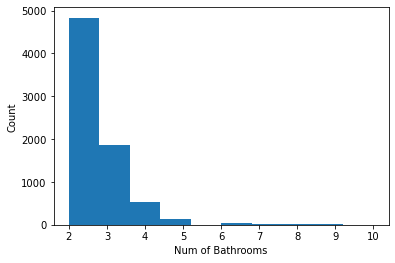

In [23]:
plt.hist(df4.Bathrooms)
plt.xlabel('Num of Bathrooms')
plt.ylabel('Count')

In [24]:
df4[df4.Bathrooms>df4.Bedrooms+1].count()

Address             33
area                33
Bedrooms            33
Bathrooms           33
neworold            33
type_of_building    33
Price_sqft          33
price               33
City                33
dtype: int64

The business manager said that if you have 4 bedrooms home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. A house that have total bath > total bedrooms + 2  is an outlier or a data error and can be removed

In [25]:
df4.shape

(7451, 9)

In [26]:
df5 = df4[df4.Bathrooms<df4.Bedrooms + 2]
df5.shape

(7418, 9)

## Removal Using standar deviation and mean

In [27]:
df5.Price_sqft.describe()

count     7418.000000
mean      5488.949648
std       2255.454055
min       2100.000000
25%       3918.367347
50%       4941.176471
75%       6303.831406
max      25925.925926
Name: Price_sqft, dtype: float64

min price is 2100 while max is 25926. We should remove outlier per location using mean and one standar deviation

In [28]:
df5.shape

(7418, 9)

In [29]:
def remove_outlier_mstd(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('City'):
        m = np.mean(subdf.Price_sqft)
        st = np.std(subdf.Price_sqft)
        reduced_df = subdf[(subdf.Price_sqft>(m-st)) & (subdf.Price_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

df6 = remove_outlier_mstd(df5)
df6.shape

(5280, 9)

Let's check if for a given location how does the 2-bedrooms house and 3-bedrooms house property prices look like

In [30]:
df6['Bedrooms'].value_counts()

2.0     2489
3.0     2372
4.0      357
5.0       30
6.0       15
7.0        6
10.0       4
8.0        4
9.0        3
Name: Bedrooms, dtype: int64

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bedrooms.

In [31]:
df6.head(2)

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price,City
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,Resale,Flat,5285.714286,11100000.0,Faridabad
1,"Sector 17, Faridabad, Delhi NCR",3150.0,3.0,3.0,Resale,Flat,3968.253968,12500000.0,Faridabad


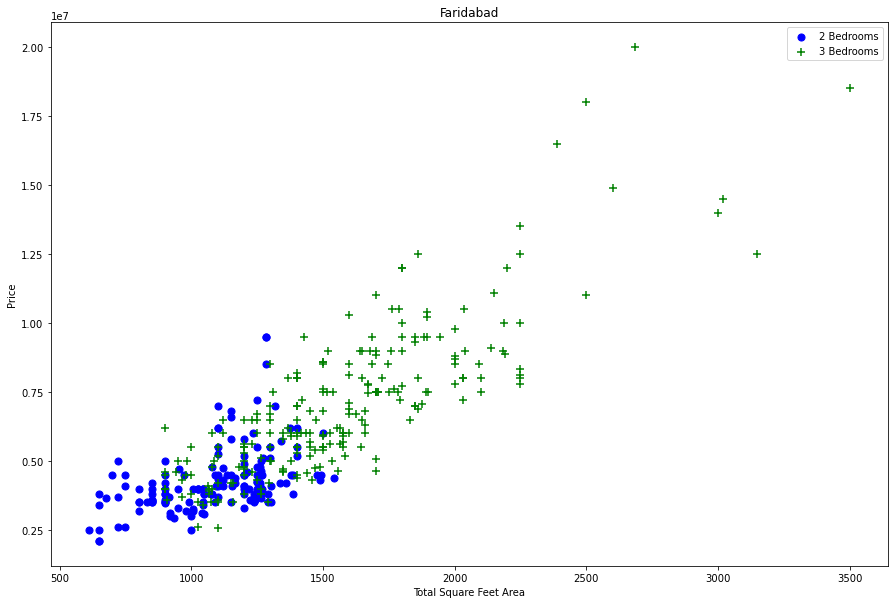

In [32]:
# def plot_scatter_chart(df,location):
#     bhk2 = df[(df.location==location) & (df.bhk==2)]
#     bhk3 = df[(df.location==location) & (df.bhk==3)]
#     matplotlib.rcParams['figure.figsize'] = (15,10)
#     plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
#     plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
#     plt.xlabel("Total Square Feet Area")
#     plt.ylabel("Price (Lakh Indian Rupees)")
#     plt.title(location)
#     plt.legend()
    
# plot_scatter_chart(df7,"Rajaji Nagar")

def plot_scatter_chart(df,City):
    bed2 = df[(df.City==City) & (df.Bedrooms==2.0)]
    bed3 = df[(df.City==City) & (df.Bedrooms==3.0)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bed2.area,bed2.price,color='blue',label='2 Bedrooms', s=50)
    plt.scatter(bed3.area,bed3.price,marker='+', color='green',label='3 Bedrooms', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(City)
    plt.legend()
    
plot_scatter_chart(df5,'Faridabad')

We should also remove properties that the price per area of (for example) 3 bedroom is less than the mean of price per area of 2 bedroom (with same square ft area)

In [33]:
df6.shape

(5280, 9)

In [34]:
df6.head()

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price,City
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,Resale,Flat,5285.714286,11100000.0,Faridabad
1,"Sector 17, Faridabad, Delhi NCR",3150.0,3.0,3.0,Resale,Flat,3968.253968,12500000.0,Faridabad
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,Resale,Flat,5000.000000,5500000.0,Faridabad
3,Second Floor Villa 83 Block III Charmwood Vill...,1908.0,4.0,3.0,Resale,Individual House,5241.090147,10000000.0,Faridabad
4,"601., Sector 21C, Faridabad, Delhi NCR",2800.0,4.0,4.0,Resale,Flat,4821.428571,13500000.0,Faridabad


In [35]:
def remove_bed_outliers(df):
    exclude_indices = np.array([])
    for city, city_df in df.groupby('City'): 
        bed_stats = {}
        for bed, bed_df in city_df.groupby('Bedrooms'):
            bed_stats[bed] = {
                'mean': np.mean(bed_df.Price_sqft),
                'std': np.std(bed_df.Price_sqft),
                'count': bed_df.shape[0]
                }
        for bed, bed_df in city_df.groupby('Bedrooms'):
            stats = bed_stats.get(bed-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bed_df[bed_df.Price_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df7 = remove_bed_outliers(df6)
df7.shape

(4103, 9)

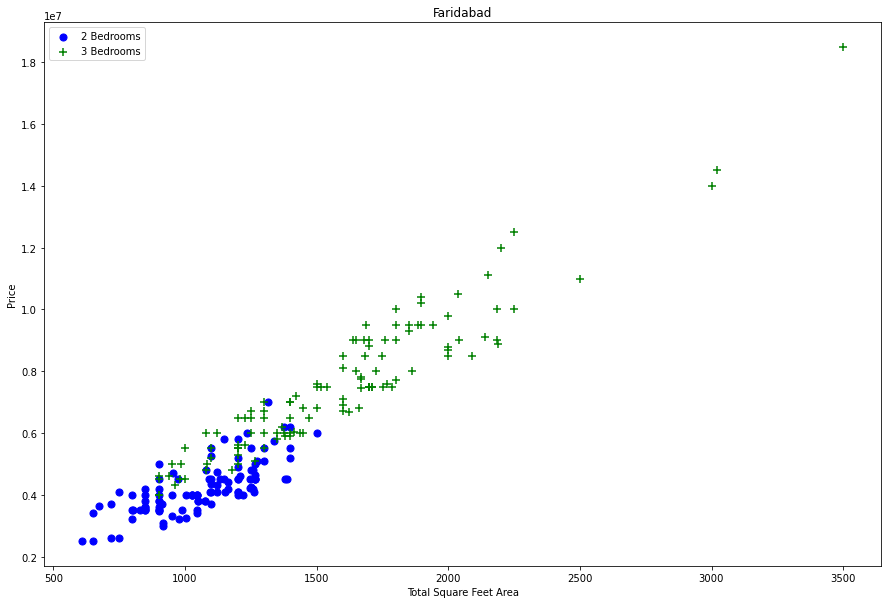

In [36]:
plot_scatter_chart(df7, 'Faridabad')

# One-Hot Encoding

### For Neworold feature

In [37]:
df7.head(2)

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price,City
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,Resale,Flat,5285.714286,11100000.0,Faridabad
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,Resale,Flat,5000.000000,5500000.0,Faridabad


In [38]:
# dummies = pd.get_dummies(df10.location)
# dummies.head(3)

# df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
# df11.head()

# df12 = df11.drop('location',axis='columns')
# df12.head(2)

In [39]:
df7.neworold.value_counts()

Resale          3714
New Property     389
Name: neworold, dtype: int64

In [40]:
dummies = pd.get_dummies(df7.neworold)
dummies

,New Property,Resale
0,0,1
2,0,1
3,0,1
4,0,1
5,0,1
...,...,...
5274,0,1
5275,1,0
5277,0,1
5278,0,1


In [41]:
df8 = pd.concat([df7, dummies], axis='columns')
df8.head(2)

,Address,area,Bedrooms,Bathrooms,neworold,type_of_building,Price_sqft,price,City,New Property,Resale
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,Resale,Flat,5285.714286,11100000.0,Faridabad,0,1
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,Resale,Flat,5000.000000,5500000.0,Faridabad,0,1


In [42]:
df9 = df8.drop('neworold', axis='columns')
df9.head(3)

,Address,area,Bedrooms,Bathrooms,type_of_building,Price_sqft,price,City,New Property,Resale
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,Flat,5285.714286,11100000.0,Faridabad,0,1
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,Flat,5000.000000,5500000.0,Faridabad,0,1
3,Second Floor Villa 83 Block III Charmwood Vill...,1908.0,4.0,3.0,Individual House,5241.090147,10000000.0,Faridabad,0,1


### For Building type feature

In [43]:
dummies2 = pd.get_dummies(df9.type_of_building)
dummies2.head()

,Flat,Individual House
0,1,0
2,1,0
3,0,1
4,1,0
5,0,1


In [44]:
df10 = pd.concat([df9, dummies2], axis='columns')
df10.head()

,Address,area,Bedrooms,Bathrooms,type_of_building,Price_sqft,price,City,New Property,Resale,Flat,Individual House
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,Flat,5285.714286,11100000.0,Faridabad,0,1,1,0
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,Flat,5000.000000,5500000.0,Faridabad,0,1,1,0
3,Second Floor Villa 83 Block III Charmwood Vill...,1908.0,4.0,3.0,Individual House,5241.090147,10000000.0,Faridabad,0,1,0,1
4,"601., Sector 21C, Faridabad, Delhi NCR",2800.0,4.0,4.0,Flat,4821.428571,13500000.0,Faridabad,0,1,1,0
5,"House No 47 Block E Floor 1 Sec 11 Faridabad,...",1350.0,3.0,2.0,Individual House,4296.296296,5800000.0,Faridabad,0,1,0,1


In [45]:
df11 = df10.drop('type_of_building', axis='columns')
df11.head()

,Address,area,Bedrooms,Bathrooms,Price_sqft,price,City,New Property,Resale,Flat,Individual House
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,5285.714286,11100000.0,Faridabad,0,1,1,0
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,5000.000000,5500000.0,Faridabad,0,1,1,0
3,Second Floor Villa 83 Block III Charmwood Vill...,1908.0,4.0,3.0,5241.090147,10000000.0,Faridabad,0,1,0,1
4,"601., Sector 21C, Faridabad, Delhi NCR",2800.0,4.0,4.0,4821.428571,13500000.0,Faridabad,0,1,1,0
5,"House No 47 Block E Floor 1 Sec 11 Faridabad,...",1350.0,3.0,2.0,4296.296296,5800000.0,Faridabad,0,1,0,1


### For City feature

In [46]:
dummies3 = pd.get_dummies(df11.City)
dummies3.head()

,Faridabad,Ghaziabad,Greater Noida,Gurgaon,Gurgaon - South,New Delhi,New Delhi - Central,New Delhi - Dwarka,New Delhi - East,New Delhi - North,New Delhi - Rohini,New Delhi - South,New Delhi - West,Noida
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
df11.City.value_counts()

Ghaziabad              1154
Gurgaon                 868
Noida                   658
Greater Noida           593
Faridabad               248
New Delhi - West        187
New Delhi - South       172
New Delhi - East         83
New Delhi - Dwarka       71
New Delhi - Rohini       33
New Delhi - North        22
New Delhi - Central       8
Gurgaon - South           3
New Delhi                 3
Name: City, dtype: int64

To save memory, when concatting, we need ro remove Gurgaon column because Gurgaon has the most data

In [48]:
df12 = pd.concat([df11,dummies3.drop('Gurgaon', axis='columns')], axis='columns')
df12.head()

,Address,area,Bedrooms,Bathrooms,Price_sqft,price,City,New Property,Resale,Flat,...,Gurgaon - South,New Delhi,New Delhi - Central,New Delhi - Dwarka,New Delhi - East,New Delhi - North,New Delhi - Rohini,New Delhi - South,New Delhi - West,Noida
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,5285.714286,11100000.0,Faridabad,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,5000.000000,5500000.0,Faridabad,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Second Floor Villa 83 Block III Charmwood Vill...,1908.0,4.0,3.0,5241.090147,10000000.0,Faridabad,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"601., Sector 21C, Faridabad, Delhi NCR",2800.0,4.0,4.0,4821.428571,13500000.0,Faridabad,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,"House No 47 Block E Floor 1 Sec 11 Faridabad,...",1350.0,3.0,2.0,4296.296296,5800000.0,Faridabad,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df13 = df12.drop('City', axis='columns')
df13.head()

,Address,area,Bedrooms,Bathrooms,Price_sqft,price,New Property,Resale,Flat,Individual House,...,Gurgaon - South,New Delhi,New Delhi - Central,New Delhi - Dwarka,New Delhi - East,New Delhi - North,New Delhi - Rohini,New Delhi - South,New Delhi - West,Noida
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,5285.714286,11100000.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,5000.000000,5500000.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Second Floor Villa 83 Block III Charmwood Vill...,1908.0,4.0,3.0,5241.090147,10000000.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"601., Sector 21C, Faridabad, Delhi NCR",2800.0,4.0,4.0,4821.428571,13500000.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,"House No 47 Block E Floor 1 Sec 11 Faridabad,...",1350.0,3.0,2.0,4296.296296,5800000.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


# Build A Model

## Use Linear Regression Model

In [50]:
df13.shape

(4103, 23)

In [51]:
#1. Separate the label (price column) and  feature (other than price column)
X = df13.drop(['price'], axis='columns')
y = df13.price

X.head(2)

,Address,area,Bedrooms,Bathrooms,Price_sqft,New Property,Resale,Flat,Individual House,Faridabad,...,Gurgaon - South,New Delhi,New Delhi - Central,New Delhi - Dwarka,New Delhi - East,New Delhi - North,New Delhi - Rohini,New Delhi - South,New Delhi - West,Noida
0,"Ashoka Enclave Part 1, Faridabad, Delhi NCR",2100.0,4.0,3.0,5285.714286,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"2 Floor, Sector 16A, Faridabad, Delhi NCR",1100.0,2.0,2.0,5000.000000,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
y.head(2)

0    11100000.0
2     5500000.0
Name: price, dtype: float64

In [53]:
len(X)

4103

In [54]:
#2 split training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=10)

ImportError: DLL load failed while importing _arpack: The specified procedure could not be found.

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test)